In [46]:
# install libraries
import influxdb_client
import pandas as pd
import secret
from sensor_data_functions import get_sensor_data
from weather_data_functions import get_weather_data
from irradiance_data_functions import irradiance_data, get_lat_long
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import math
import pytz
import ast

In [47]:
year = 2023
month = 12
day = 13
date_time = datetime(year=year, month=month, day=day)

generation_df, consumption_df = get_sensor_data(date_time)

generation_df.head()

Data not found in local storage, querying influxdb


,power
datetime,
2023-12-13 00:00:00+00:00,0.084176
2023-12-13 00:00:01+00:00,0.083553
2023-12-13 00:00:02+00:00,0.085339
2023-12-13 00:00:03+00:00,0.082939
2023-12-13 00:00:04+00:00,0.085323


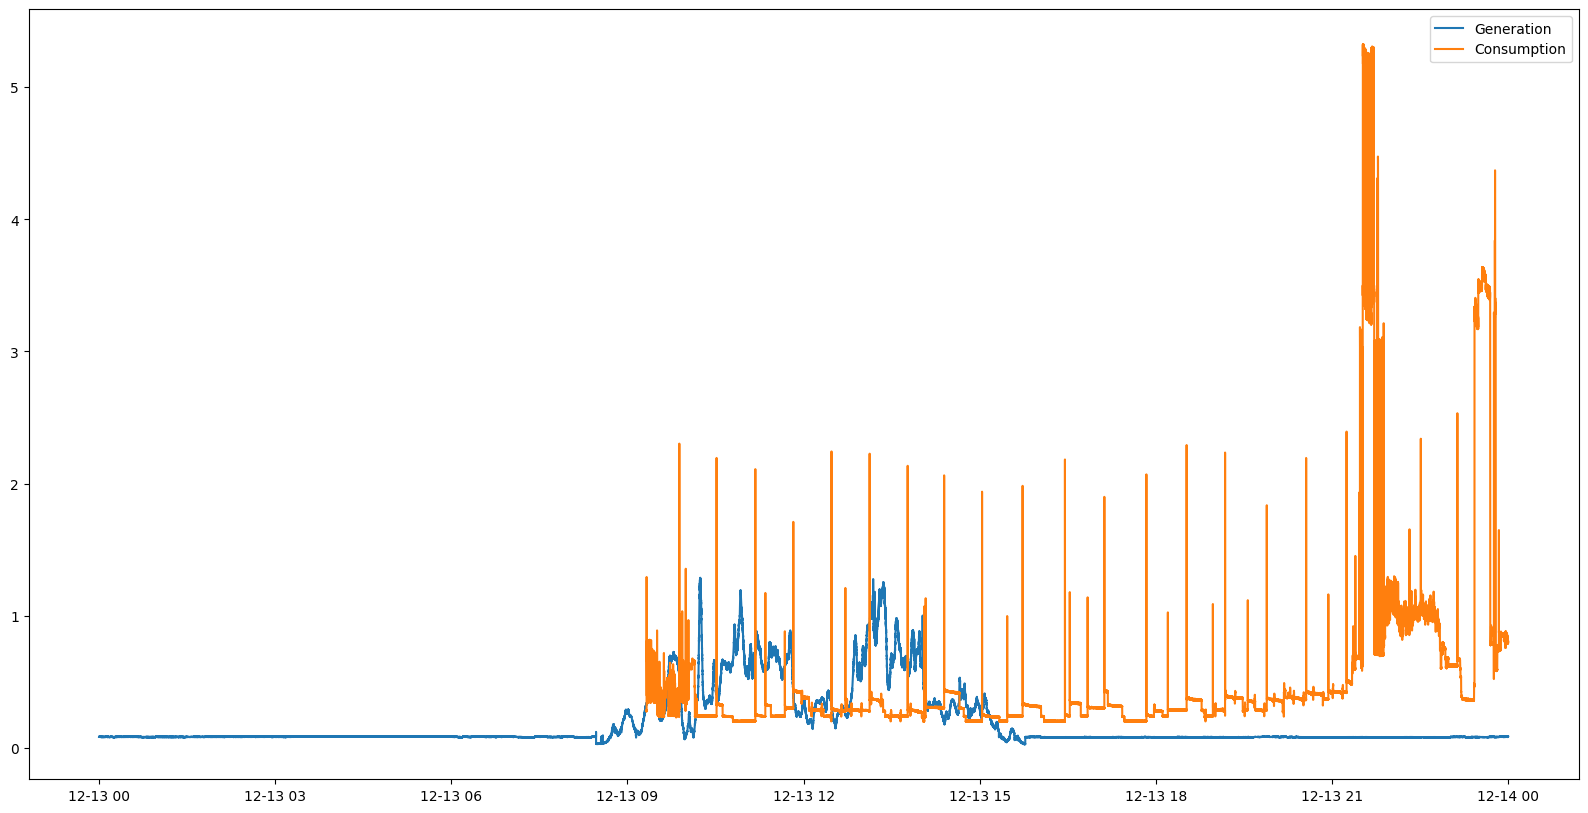

In [48]:
# plot both generation and consumption
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(generation_df.index, generation_df['power'], label='Generation')
ax.plot(consumption_df.index, consumption_df['power'], label='Consumption')
ax.legend()

In [49]:
postcode = 'WR7 4BU'

weather = get_weather_data(postcode, date_time)
weather.head()

Weather data loaded from API


,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,condition
time,,,,,,,,,,,,,,,,,,,,,
2023-12-13 00:00:00,1702425600,7.0,44.6,0,6.3,10.1,359,N,996.0,29.43,...,0,0,0,0,2.0,1.0,10.2,16.5,1.0,Mist
2023-12-13 01:00:00,1702429200,7.0,44.7,0,7.2,11.5,351,N,997.0,29.44,...,0,45,0,0,2.0,1.0,11.3,18.2,1.0,Mist
2023-12-13 02:00:00,1702432800,7.0,44.6,0,7.6,12.2,344,NNW,998.0,29.46,...,0,45,0,0,10.0,6.0,11.8,19.0,1.0,Overcast
2023-12-13 03:00:00,1702436400,7.0,44.7,0,8.9,14.4,338,NNW,998.0,29.48,...,0,45,0,0,10.0,6.0,13.5,21.7,1.0,Overcast
2023-12-13 04:00:00,1702440000,6.9,44.4,0,10.3,16.6,342,NNW,999.0,29.51,...,0,45,0,0,10.0,6.0,15.3,24.6,1.0,Patchy rain possible


In [50]:
irradiance = irradiance_data(postcode, date_time)
irradiance

No local data available, calling API


,start,end,start_time,clear_sky_ghi,clear_sky_dni,clear_sky_dhi,cloudy_sky_ghi,cloudy_sky_dni,cloudy_sky_dhi
0,00:00,00:15,2023-12-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,00:15,00:30,2023-12-13 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0
2,00:30,00:45,2023-12-13 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
3,00:45,01:00,2023-12-13 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0
4,01:00,01:15,2023-12-13 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
91,22:45,23:00,2023-12-13 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0
92,23:00,23:15,2023-12-13 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0
93,23:15,23:30,2023-12-13 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0
94,23:30,23:45,2023-12-13 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0
